In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import random


In [2]:
def find_matching_keypoints(image1, image2):
    #Input: two images (numpy arrays)
    #Output: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    good = []
    pts1 = []
    pts2 = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.8 * n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1, pts2

def drawlines(img1,img2,lines,pts1,pts2):
    #img1: image on which we draw the epilines for the points in img2
    #lines: corresponding epilines
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [3]:
def Find_distance(points, mean):
    distance = []
    for i in range(len(points)):
        x = ((points[i][0] - mean[0]) ** 2) + ((points[i][1] - mean[1]) ** 2)
        euclidean  = np.sqrt(x)
        distance.append(euclidean)
    return distance

def transform_matrix(mean, sf):
    transformed = np.zeros((3,3))
    transformed = [[sf,  0, -1 * sf * mean[0]],[0, sf, -1 * sf * mean[1]],[0,0,1]]
    return transformed
def FindFundamentalMatrix(pts1, pts2):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))

    #todo: Normalize the points
    mean1 = np.zeros(2)
    mean2 = np.zeros(2)


    for i in range(len(pts1)):
        mean1[0]+=pts1[i][0]
        mean1[1]+=pts1[i][1]
    mean1[0] = mean1[0] / len(pts1)
    mean1[1] = mean1[1] / len(pts1)
    for j in range(len(pts2)):
        mean2[0]+=pts2[j][0]
        mean2[1]+=pts2[j][1]
    mean2[0] = mean2[0] / len(pts2)
    mean2[1] = mean2[1] / len(pts2)

    dist1 = Find_distance(pts1, mean1)
    dist2 = Find_distance(pts2, mean2)

    sf1 = ((2 ** 0.5) * len(pts1))/ np.sum(dist1)
    sf2 = ((2 ** 0.5) * len(pts2))/ np.sum(dist2)
    Tf1 = transform_matrix(mean1, sf1)
    Tf2 = transform_matrix(mean2, sf2)

    Tf1 = np.array(Tf1)
    Tf2 = np.array(Tf2)

    pts1 = [Tf1 @ np.array([a[0], a[1], 1]) for a in pts1]
    pts2 = [Tf2 @ np.array([b[0], b[1], 1]) for b in pts2]
    
    pts1 =  np.array(pts1)
    pts2 =  np.array(pts2)

    #todo: Form the matrix A
    A= np.zeros((len(pts1),9))
    for i in range(len(pts1)):
        A[i][0] = pts1[i][0] * pts2[i][0]
        A[i][1] = pts2[i][0] * pts1[i][1]
        A[i][2] = pts2[i][0]
        A[i][3] = pts2[i][1] * pts1[i][0]
        A[i][4] = pts2[i][1] * pts1[i][1]
        A[i][5] = pts2[i][1]
        A[i][6] = pts1[i][0]
        A[i][7] = pts1[i][1]
        A[i][8] = 1.0

    #todo: Find the fundamental matrix
    _,_, v = np.linalg.svd(A)
    fundamental = np.reshape(v.transpose()[:,8],(3,3))
    u,e,vt = np.linalg.svd(fundamental)
    e[-1] = 0
    fundamental = u @ np.diag(e) @ vt
    f_matrix = Tf2.T @ fundamental @ Tf1
    #f_matrix /= f_matrix[-1,-1]
    return f_matrix

In [4]:
def FindFundamentalMatrixRansac(pts1, pts2, num_trials = 2000, threshold = 0.01):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))
    inliers = np.zeros(num_trials)
    best_fundamental = np.empty((3,3))
    pts1 =  np.array(pts1)
    pts2 =  np.array(pts2)
    for j in range(num_trials):
        points_indices = np.random.choice(155, 8, replace=False)
        points1 = pts1[points_indices]
        points2 = pts2[points_indices]

        p_indices = [a for a in range(len(pts1)) if a not in points_indices]
  
        p1 = pts1[p_indices]
        p2 = pts2[p_indices]

        fund = FindFundamentalMatrix(points1, points2)
        #fund = np.array(fund)
        pt1 = np.array([[a[0], a[1], 1] for a in p1])
        pt2 = np.array([[a[0], a[1], 1] for a in p2])
        
        for i in range(len(pt1)):
            x_prime = pt2[i]
            x = pt1[i]
            t = x_prime @ fund @ np.transpose(x)
            t = np.absolute(t)
            #print(t)
            if t <= threshold:
                inliers[j]+=1
        if j>0 and (inliers[j] > inliers[j-1]):
            best_fundamental = fund


    #todo: Run RANSAC and find the best fundamental matrix
    return best_fundamental
    raise NotImplementedError


In [6]:

if __name__ == '__main__':
    #Set parameters
    data_path = './data'
    use_ransac = True

    #Load images
    image1_path = os.path.join(data_path, 'mount_rushmore_1.jpg')
    image2_path = os.path.join(data_path, 'mount_rushmore_2.jpg')
    image1 = np.array(Image.open(image1_path).convert('L'))
    image2 = np.array(Image.open(image2_path).convert('L'))


    #Find matching keypoints
    pts1, pts2 = find_matching_keypoints(image1, image2)  

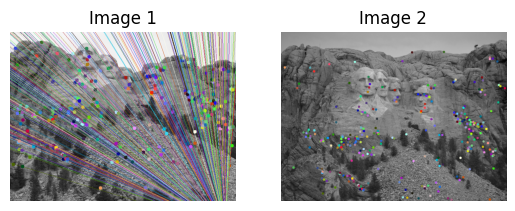

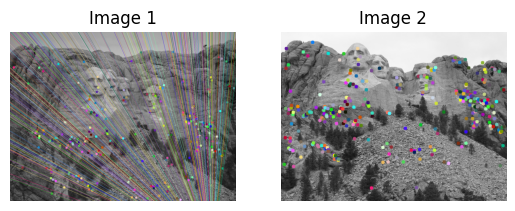

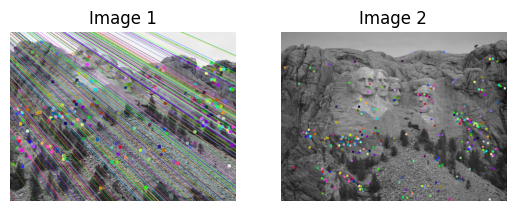

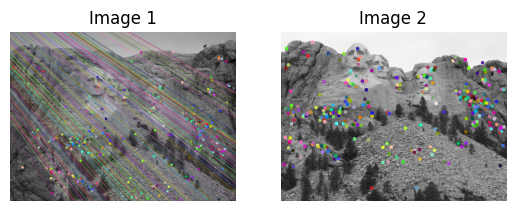

In [8]:
F1= FindFundamentalMatrixRansac(pts1, pts2)
F2_true = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)[0]
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F2_true)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)
plt.title("OPENCV IMPLEMENTATION FOR IMAGE 1")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F2_true)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)
plt.title("OPENCV IMPLEMENTATION FOR IMAGE 2")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F1)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)
plt.title("USER DEFINED RANSAC IMPLEMENTATION FOR IMAGE 1")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F1)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)
plt.title("USER DEFINED RANSAC IMPLEMENTATION FOR IMAGE 2")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')



plt.show()


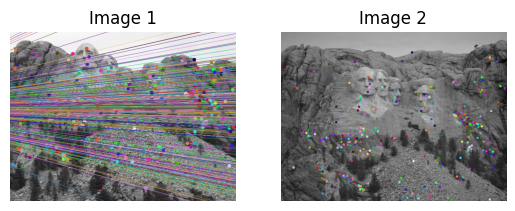

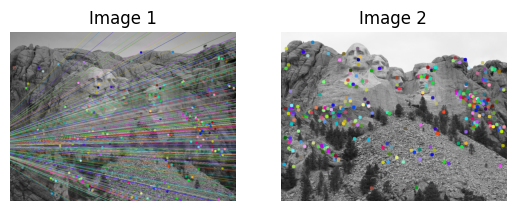

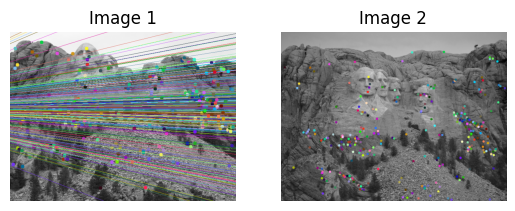

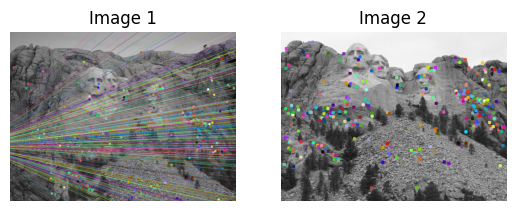

In [9]:
# Find epilines corresponding to points in second image,  and draw the lines on first image
F_true = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)[0]
F2 = FindFundamentalMatrix(pts1, pts2)
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F_true)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)
plt.title("OPENCV IMPLEMENTATION FOR IMAGE 1")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F_true)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)
plt.title("OPENCV IMPLEMENTATION FOR IMAGE 2")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F2)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)
plt.title("USER DEFINED RANSAC IMPLEMENTATION FOR IMAGE 1")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F2)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)
plt.title("USER DEFINED RANSAC IMPLEMENTATION FOR IMAGE 2")
axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')



plt.show()


In [54]:
print(F1/F1[-1,-1])

[[-3.20438708e-06 -6.80758368e-05  4.30800988e-02]
 [ 6.64857759e-05 -3.03688489e-06 -3.89761070e-02]
 [-6.37186402e-02  6.31058640e-02  1.00000000e+00]]


In [55]:
print(F2_true)

[[-4.93690349e-06 -1.53955570e-04  9.04656341e-02]
 [ 1.43855035e-04 -9.72932189e-06 -8.39765050e-02]
 [-1.33093143e-01  1.44107712e-01  1.00000000e+00]]


In [56]:
print(F2/F2[-1,-1])

[[-6.21019078e-07  1.94057859e-05 -4.61012984e-03]
 [-9.63274968e-06 -3.36322689e-06 -3.39544243e-03]
 [ 4.69881036e-03  4.57321966e-03  1.00000000e+00]]


In [57]:
print(F_true)

[[-6.21019078e-07  1.94057859e-05 -4.61012984e-03]
 [-9.63274968e-06 -3.36322689e-06 -3.39544243e-03]
 [ 4.69881036e-03  4.57321966e-03  1.00000000e+00]]
